Previous: [Synchronization](pipeline_synchronization.ipynb)  ::: Next [Process Movie](pipeline_prepare_movie.ipynb) 
# Example: processing the Monet stimulus
In this notebook, we retrieve spikes inferred from the calcium traces and the synchronized visual stimuli of the type "Monet". 

In [1]:
%pylab inline
import datajoint as dj
from pipeline import preprocess, vis

Populating the interactive namespace from numpy and matplotlib
DataJoint 0.3.5 (July 21, 2016)
Loading local settings from dj_local_conf.json
Connecting dimitri@datajoint.ninai.org:3306


First, let's for the query for the trials with the Monet stimulus.  The ERD below shows the relevant tables.

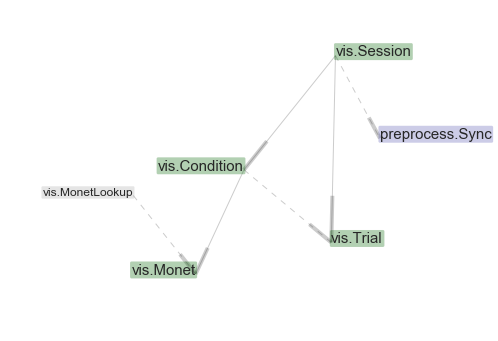

In [2]:
(dj.ERD(vis.Monet)-2 + preprocess.Sync + vis.Trial).draw()

The following query denotes all trials combined with synchronization information to the two-photon scan.

In [3]:
trials = preprocess.Sync() * vis.Trial() & 'trial_idx between first_trial and last_trial'

The `preprocess.Sync` table matches the calcium data with the visual stimuli. It identifies a sinlge two-photon recording but also refers to the visual session `vis.Session`.

The query uses the fields `first_trial` and `last_trial` in `preprocess.Sync` to select the correct trials from the matching visual session.

---
Now the table `preprocess.Spikes` groups a set of spike traces inferred from calcium recordings processed in one particular way. The traces themselves are stored in its part table `preprocess.Spikes.RateTrace`.

Below is the relevant ERD.

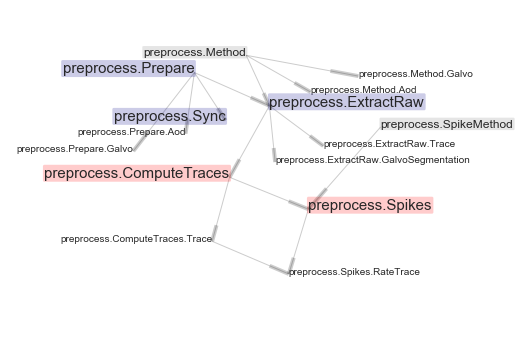

In [4]:
(dj.ERD(preprocess.Spikes)-3+1).draw()

Thus the following query identifies all the datasets recorded with Monet trials:

In [5]:
monet_datasets = preprocess.Spikes() & (trials & vis.Monet())

Some of these datasets represent the same recordings processed in different ways, which are enumerated in the lookup tables `preprocess.Method` and `preprocess.SpikeMethod`:

In [6]:
preprocess.Method() * preprocess.Method.Galvo()    # extraction methods for galvo microscopes

extract_method,segmentation
1,manual
2,nmf


In [7]:
preprocess.SpikeMethod()

spike_method,spike_method_name,spike_method_details,language
2,fastoopsi,nonnegative sparse deconvolution from Vogelstein (2010),matlab
3,stm,spike triggered mixture model from Theis et al. (2016),python
4,improved oopsi,,matlab
5,nmf,,matlab


We restrict the datasets to one processing method:

In [8]:
monet_datasets = (preprocess.Spikes() & 
                  (trials & vis.Monet()) & 
                  dict(extract_method=2, spike_method=5))
monet_datasets

animal_id,session,scan_idx,extract_method,spike_method
7816,1,11,2,5
7816,1,20,2,5
7816,1,24,2,5
7816,1,26,2,5
7816,1,27,2,5
7816,1,28,2,5
7816,1,29,2,5


---
Now let's fetch the primary key values of these datasets so that we can address them individually:

In [9]:
keys = list(monet_datasets.fetch.keys())     # keys for relevant datasets
key = keys[3]   #  identifies one dataset
dict(key)

{'animal_id': 7816,
 'extract_method': 2,
 'scan_idx': 26,
 'session': 1,
 'spike_method': 5}

---
Now let's fetch all the relevant information for the dataset identified by `key`:

In [10]:
time = (preprocess.Sync() & key).fetch1['frame_times'].squeeze()  # calcium scan frame times
traces = np.vstack((preprocess.Spikes.RateTrace() & key).fetch['rate_trace'])  # fetch traces
nslices = len(time)/traces.shape[1]   # number of slices in recording.
time = time[::nslices]   # keep only one timestamp per frame (ignore time offsets of slices)

----
Now let's iterate through the visual trials:

In [11]:
for trial_key in (trials & key).fetch.order_by('trial_idx').keys():
    print(dict(trial_key))

{'trial_idx': 109, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 110, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 111, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 112, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 113, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 114, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 115, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 116, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 117, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 118, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 119, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 120, 'animal_id': 7816, 'session': 1, 'scan_idx': 26, 'psy_id': 5}
{'trial_idx': 121, 'animal_i

Now let's just look at the last trial addressed by `trial_key` (the last iteration of the loop above) and retrieve the stimulus movie shown during the trial:

In [12]:
stimulus_info = (vis.Trial()*vis.Monet()*vis.MonetLookup() & trial_key).fetch1()

The `flip_times` field contains the time stamps of the frames of the movie on the same clock and same units as the `time` retrieved earlier for calcium traces from `preprocess.Sync`:

In [13]:
stimulus_info['flip_times'].flatten()   # the frame times of the visual stimulus

array([  1.45514462e+09,   1.45514462e+09,   1.45514462e+09, ...,
         1.45514468e+09,   1.45514468e+09,   1.45514468e+09])

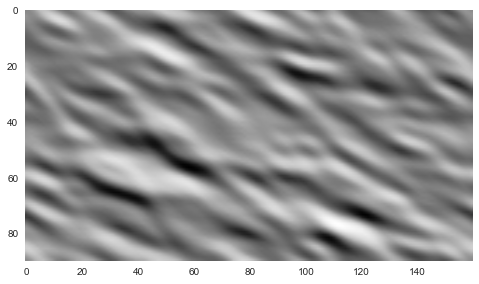

In [14]:
plt.imshow(stimulus_info['cached_movie'][:,:,100])   # show a frame from the movie
plt.grid(False)

The stimulus comprises periods of coherent motion.  The times and directions are contained in 

In [15]:
stimulus_info['params'][3]['direction'][0,0].flatten()   # radians

array([ 0.39269908,  4.3196899 ,  0.        ,  2.35619449,  3.14159265,
        2.74889357,  0.78539816,  5.10508806,  5.49778714,  4.71238898,
        3.92699082,  1.57079633,  1.17809725,  3.53429174,  1.96349541,
        5.89048623])

In [16]:
stimulus_info['params'][3]['onsets'][0,0].flatten()    # motion onset times (s)

array([  1.375,   5.125,   8.875,  12.625,  16.375,  20.125,  23.875,
        27.625,  31.375,  35.125,  38.875,  42.625,  46.375,  50.125,
        53.875,  57.625])

In [17]:
stimulus_info['params'][3]['onsets'][0,0].flatten()    # motion offset times (s)

array([  1.375,   5.125,   8.875,  12.625,  16.375,  20.125,  23.875,
        27.625,  31.375,  35.125,  38.875,  42.625,  46.375,  50.125,
        53.875,  57.625])

In [18]:
stimulus_info['params'][3]['frametimes'][0,0].flatten()  # movie frame times (s) within trial

array([  0.00000000e+00,   1.66666667e-02,   3.33333333e-02, ...,
         5.99500000e+01,   5.99666667e+01,   5.99833333e+01])

---
That's it.  That is all it takes to map receptive fields and directional tunign of cells using the Monet stimulus.

Next [Process Movie](pipeline_prepare_movie.ipynb) 